In [1]:
%load_ext autoreload 
# saving changes to code reloads them in the environment
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import sys
import funcy
from __future__ import division
import numpy as np
import scipy.optimize as spo
import pandas as pd
from collections import defaultdict
from code.gradient_descent import _gradient_descent, gradient_descent, SGD, g_error, b_error 
from code.helpers import f_gauss, d_gauss, f_bowl, d_bowl, get_lr
from code.basis_func import create_basis, create_cos_basis, BasisSearch, plotter
from code.constants import *

In [2]:
def arr(*args):
    return np.array(map(float,args)) # shorthand

In [3]:
bs =  BasisSearch(M=2)

In [4]:
data = pl.loadtxt('hw1code/P2/curvefittingp2.txt')

X = data[0,:]
Y = data[1,:]
pts = np.array([[p] for p in pl.linspace(min(X), max(X), 100)])

**Note: Bishop plots in figures/ directory for 2.1**

In [5]:
from code.helpers import X1

In [6]:
X1.shape

(100, 10)

### 2.2 Gradient for SSE is reasonably approximated by numerical derivative



In [7]:
def d_sse(theta, *args):
    '''Gradient of loss function w.r.t weights <theta> for #2.2'''
    Xt = create_basis(X, M=theta.size-1)
    yhat = predict(theta)
    errors = yhat - Y
    return 2 * Xt.T.dot(errors)

def predict(theta, X=X, Y=Y):
    Xt= create_basis(X, M=theta.size-1)
    return Xt.dot(theta)

In [8]:
def sse(weights):
    return np.sum((predict(weights) - Y) **2)

In [9]:
from code.gradient_descent import numerical_gradient

In [17]:
def grad_error(weights=np.array([0., 0, 0]), h=1e-3):
    '''Avg. Absolute Deviation between analytical and numeric derivative'''
    return np.abs((numerical_gradient(weights, sse, h=h)
                   - d_sse(weights))).mean()

In [11]:
numerical_gradient(np.array([0.,0]), sse, h=1)

array([ 0.0192 ,  3.99782])

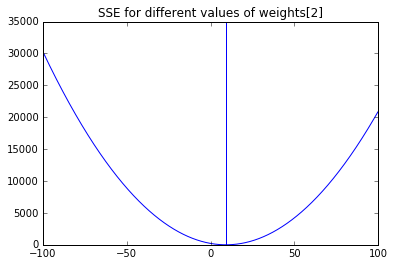

In [14]:
ser = pd.Series({x: sse(np.array([2.5,-12, x, 1])) 
           for x in np.arange(-100,100,.1)})
plt.axvline(ser.idxmin())
ax = ser.plot()
ax.set_title('SSE for different values of weights[2]')

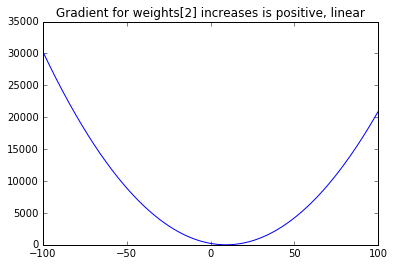

In [15]:
grad_ser = pd.Series({x: d_sse(np.array([2.5,-12, x]))[-1]
           for x in np.arange(-100,100,.1)})#plot()
#plt.axvline(ser.idxmin())
plt.axhline(0, color='black')
ax = ser.plot()
ax.set_title("Gradient for weights[2] increases is positive, linear")

Numeric Gradient is close to Analytical for all reasonable values of H!


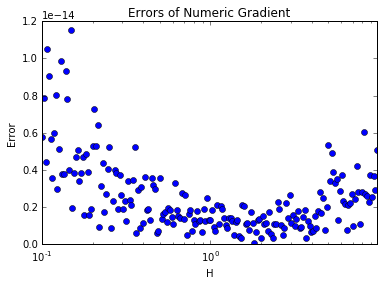

In [18]:
hvals = [10**x for x in np.arange(-1, 1, .01)]

ax = pd.Series({h: grad_error(h=h) for h in hvals}).plot(
    logx=True, 
    style='o')
ax.set_xlabel('H')
ax.set_ylabel('Error')
ax.set_title('Errors of Numeric Gradient')


## 2.3: Hyper Parms for BGD on different values of M

In [19]:
M = 0
def search_sgd(M, lrs=np.logspace(-1.1, -1, 20)):
    '''Find result of gradient descent for many learning rates'''
    return pd.Series({l: gradient_descent(sse, deriv_func=d_sse, 
                     init_weights=np.zeros(M+1),
                  lr=l) for l in lrs}).apply(pd.Series)

In [20]:
M = 0
def search(M, lrs=np.logspace(-1.1, -1, 20)):
    '''Find result of gradient descent for many learning rates'''
    return pd.Series({l: gradient_descent(sse, deriv_func=d_sse, 
                     init_weights=np.zeros(M+1),
                  lr=l) for l in lrs}).apply(pd.Series)

def lr_plot(res):
    '''Note large values are replaced with np.nan, so no dots for gradient explosions'''
    ax = np.clip(res, None,10).replace(10, np.nan).plot(style='-o')
    ax.set_title('Learning Rate vs. Gradient Result')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Final Weight')
    return ax

In [21]:
res1 = search(1,lrs=np.linspace(10**-4, 10**-1., 10))

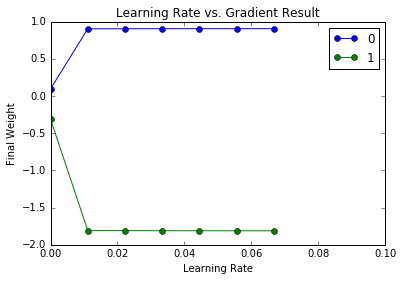

In [22]:
lr_plot(res1)

In [23]:
res9 = search(9,lrs=np.linspace(10**-4, 10**-1., 10))

**Learning Rates for BGD:**

- Should be between .02 and .06
- More leniency for smaller M, but not by a huge amount

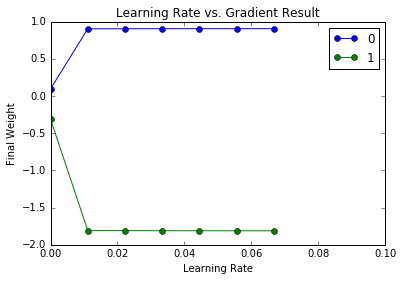

In [24]:
lr_plot(res1)

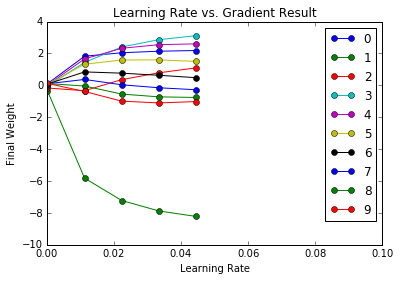

In [25]:
lr_plot(res9)  # M=9

In [26]:
res3 = search(3,lrs=np.linspace(10**-4, 10**-1., 10))

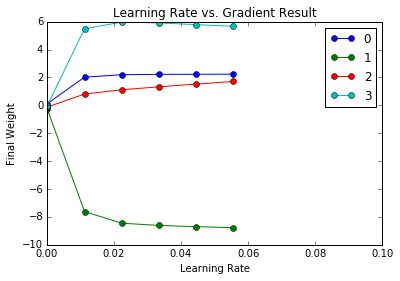

In [27]:
lr_plot(res3)

In [28]:
from code.gradient_descent import SGD

In [32]:
def SGD2(M, **kwargs):
    Xt = create_basis(X, M=M)
    return SGD(init_weights=np.zeros(Xt.shape[1]),
               X=Xt, Y=Y, **kwargs)

In [33]:
sgw, sgp = SGD2(2)

done in 2 steps


In [36]:
target = BasisSearch(M=2).coef[0]
print 'target = {}'.format(target)

target = 2.45618251748


In [37]:
def path_compare(M=2):
    batch_weight, batch_path = _gradient_descent(sse, 
                                             deriv_func=d_sse, 
                     init_weights=np.zeros(M+1),
                  lr=.04, max_iter=1000)
    sgd_w, sgd_path = SGD2(2, lr=.25, stop_crit=1e-8,max_iter=1000)
    ax = pd.DataFrame({'BGD': batch_path.w0, 'SGD':sgd_path.w0}).plot()
    ax.set_title('Batch vs. Gradient Descent Paths for W0')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('W0')

**SGD vs. BGD:**
- SGD needs a higher learning rate to converge to 2.5 for all values of M

**SGD Stopping and Learning Schedule:**
- Lower stopping criteria reduce the probability of stopping, regardless of whether the algorithm is stuck at a local minima or at the target. Luckily, the decreasing learning schedule means that the weight does not fluctuate wildly near convergence, even if it doesnt meet the desired stability. 
- The `k` parameter impacts the steepness of the learning schedule, the `TAU` parameter impacts the level, much like learning rate for BGD



done in 999 steps


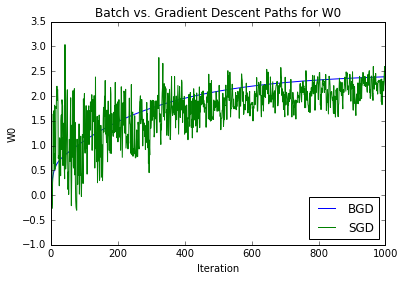

In [38]:
path_compare()

done in 999 steps


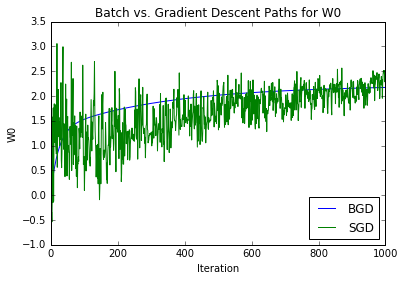

In [39]:
path_compare(M=9)

## 2.4 Learn Cosine Weights

Cosine weights are close but not identical to the true coefficients. Fitting a 9 parameter model to 11 variables of data results, as expected in over-fitting. The learned solution is has lower L2 loss than the true data generation process. We need a sparsity penalty to the loss function.
Plot at `figures/2.4_weights.png`


In [40]:
from code.basis_func import cos_descent

In [41]:
z_start = pd.Series({n: cos_descent(n) for n in range(1, 9)})
zdf = z_start.apply(pd.Series)#.fillna(0)

In [42]:
zdf.round(2).rename_axis('Weight', 1).rename_axis('M', 0)

Weight,0,1,2,3,4,5,6,7
M,,,,,,,,
1,0.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.78,1.17,NaN,NaN,NaN,NaN,NaN,NaN
3,0.76,1.17,0.09,NaN,NaN,NaN,NaN,NaN
4,0.76,1.14,0.09,0.20,NaN,NaN,NaN,NaN
5,0.77,1.14,0.10,0.20,-0.05,NaN,NaN,NaN
6,0.77,1.09,0.10,0.15,-0.05,0.36,NaN,NaN
7,0.77,1.09,0.10,0.15,-0.05,0.36,0.01,NaN
8,0.77,1.09,0.10,0.14,-0.05,0.36,0.01,0.02


In [45]:
M=2
Xcos = create_cos_basis(X, M=M)
truth = np.array([ 1.,  1.5,  0.,  0.,  0.,  0.,  0.,  0.,  ]) # coefficients
def loss(w):
    Xcos = create_cos_basis(X, M=w.size)
    return np.sum((np.array(Xcos).dot(w) - Y)**2)
start = np.zeros(Xcos.shape[1])

z_start = pd.Series({n: cos_descent(n) for n in range(1,9)})
zdf = z_start.apply(pd.Series).fillna(0)
learned_weights = zdf.loc[8]



In [46]:
print loss(z_start[8])
loss(truth)

0.515786816921


2.4946764880631989

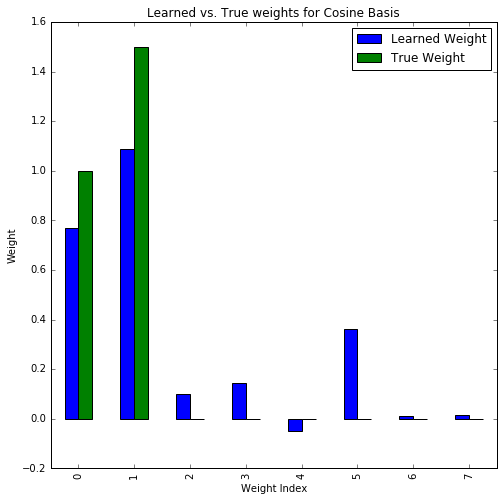

In [47]:

ax = pd.DataFrame({'True Weight': truth, 'Learned Weight': z_start[8]}).plot.bar(figsize=(8,8))

ax.set_xlabel('Weight Index')
ax.set_ylabel('Weight')
ax.set_title('Learned vs. True weights for Cosine Basis')
#plt.savefig('figures/2.4_weights.png')

In [537]:
!open figures/2.4_weights.png